In [34]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold # import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import SelectFromModel

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import yellowbrick as yb

from utilities import timeseries_train_test_split

### Predict Energy consumption

In [35]:
dataset = pd.read_csv('data1/dataset_los_angeles.csv')

In [36]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Cooling:Electricity [kW](Hourly)',
       'Date/Time', 'Electricity:Facility [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Labor Day',
       'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day

In [37]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_CA_LOS_ANGELES']]

In [38]:
dataset_numeric.describe()

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Hourly)_lag,Electricity:Facility [kW](Hourly)_future,Electricity:Facility_delta_current_lag,Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),...,RefBldgPrimarySchoolNew,RefBldgQuickServiceRestaurantNew,RefBldgSecondarySchoolNew,RefBldgSmallHotelNew,RefBldgSmallOfficeNew,RefBldgStand-aloneRetailNew,RefBldgStripMallNew,RefBldgSuperMarketNew,RefBldgWarehouseNew,USA_CA_LOS_ANGELES
count,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,...,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.0
mean,57.491548,201.200710,201.047503,201.180339,0.153207,15.835185,57.605681,0.122978,31.825344,53.220947,...,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062350,1.0
std,124.613103,323.144690,323.021505,323.150895,445.461908,26.622142,113.911321,1.307583,91.100063,83.215305,...,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.241791,0.0
min,0.000000,1.925019,1.925019,1.925019,-1412.796755,0.000000,0.000000,0.000000,0.000000,1.011600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,24.203202,24.177402,24.196641,-94.410885,0.000000,0.813655,0.000000,0.000000,8.092797,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,1.441369,58.456455,58.393697,58.393697,9.744958,3.714125,8.367722,0.000000,0.000000,20.643869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,27.200588,217.959965,217.685318,217.959965,104.096757,20.023110,46.493588,0.000000,5.835806,53.238744,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,510.349050,1517.034396,1517.034396,1517.034396,1371.428451,161.591212,1151.358784,78.271090,1146.504524,448.566544,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [39]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)_future"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)_future      1.000000
RefBldgLargeHotelNew                          0.674131
Water Heater:WaterSystems:Gas [kW](Hourly)    0.610592
RefBldgMediumOfficeNew                        0.441999
InteriorEquipment:Gas [kW](Hourly)            0.244139
Electricity:Facility [kW](Hourly)_lag         0.243555
Gas:Facility [kW](Hourly)                     0.168768
RefBldgSmallHotelNew                          0.126537
InteriorEquipment:Electricity [kW](Hourly)    0.094130
RefBldgLargeOfficeNew                         0.070689
Heating:Electricity [kW](Hourly)              0.062543
InteriorLights:Electricity [kW](Hourly)       0.062257
Electricity:Facility [kW](Hourly)             0.049251
is_weekend                                    0.036582
Monday                                        0.028158
Cooling:Electricity [kW](Hourly)              0.028127
Sunday                                        0.026972
Tuesday                                       0.025767
Fans:Elect

In [40]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
dataset_numeric_scaling = dataset_numeric[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover']]
scaled_df = scaler.fit_transform(dataset_numeric_scaling)
scaled_df = pd.DataFrame(scaled_df, columns=['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover'])

one_hot_encoded_data = dataset_numeric[['Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_CA_LOS_ANGELES']]

In [41]:
processed_data = pd.concat((scaled_df, one_hot_encoded_data), axis=1)

In [42]:
processed_data.columns

Index(['Cooling:Electricity [kW](Hourly)', 'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'is_weekend',
       'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', '

In [43]:
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                            'InteriorEquipment:Electricity [kW](Hourly)',
                            'Fans:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility_delta_current_lag',
                           'Heating:Electricity [kW](Hourly)',
                            'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_CA_LOS_ANGELES',
        'time', 'sunriseTime', 'sunsetTime']]

dataset_labels = processed_data['Electricity:Facility [kW](Hourly)_future']

In [44]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)
X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)

Linear Regression model
Mean Squared Error: 0.189
Coefficient of Determination: 0.810
Coefficients: [ 1.87472092e-01  4.56361349e-02  1.91307148e-01 -3.57541503e-02
 -1.88735562e+11  1.88663615e+11  2.60176033e+11 -1.30456999e-02
  3.67906376e-02  7.24900120e-02 -7.51344433e-03  1.49795157e-02
 -1.63333301e-02  1.35427420e-03  5.42443081e-04 -1.83769248e-01
  4.58436506e-02 -1.77070625e-01  6.70915084e-02  2.31792543e-02
  2.69317267e-02 -1.28489404e-02  2.78082541e-02  2.62836461e-02
 -3.51112698e-02  1.15856343e+12 -2.62680650e-02 -8.88192851e+11
 -8.88192851e+11 -2.04675628e+12 -2.04675628e+12 -8.88192851e+11
 -8.88192851e+11 -8.88192851e+11 -6.76338440e+11 -6.76338440e+11
 -6.76338440e+11 -6.76338440e+11 -6.76338440e+11 -6.76338440e+11
 -6.76338440e+11 -6.76338440e+11 -6.76338440e+11 -6.76338440e+11
 -6.76338440e+11 -6.76338440e+11 -6.76338440e+11 -6.76338440e+11
 -6.76338440e+11 -6.76338440e+11  3.12500000e-01 -4.45513298e+01
  2.82019157e+01  1.63550535e+01]


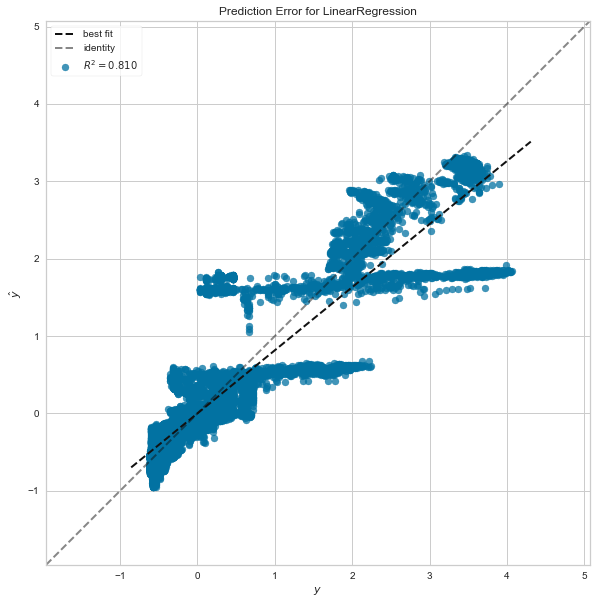

In [45]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)
from yellowbrick.regressor import PredictionError
model = LinearRegression(normalize=True)
est = model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
print('Coefficients: {}'.format(model.coef_))
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Ridge model
Mean Squared Error: 0.205
Coefficient of Determination: 0.793


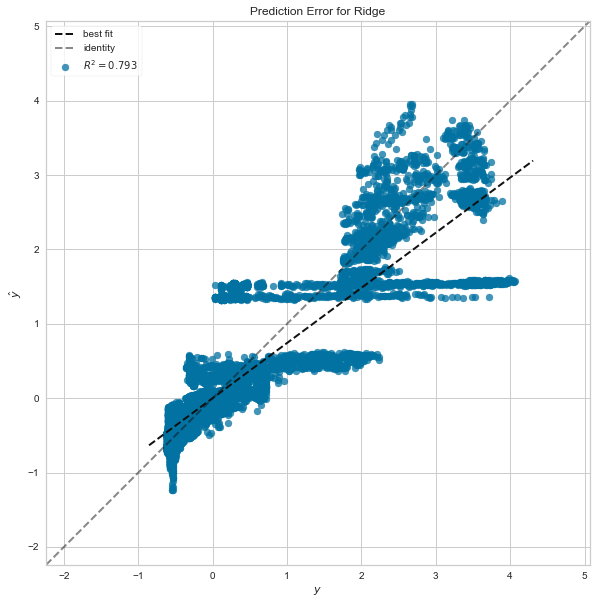

In [46]:
# X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

expected = y_test
predicted = ridge.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(ridge, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()         

Ridge model
Mean squared error = 0.189
R2 score = 0.810


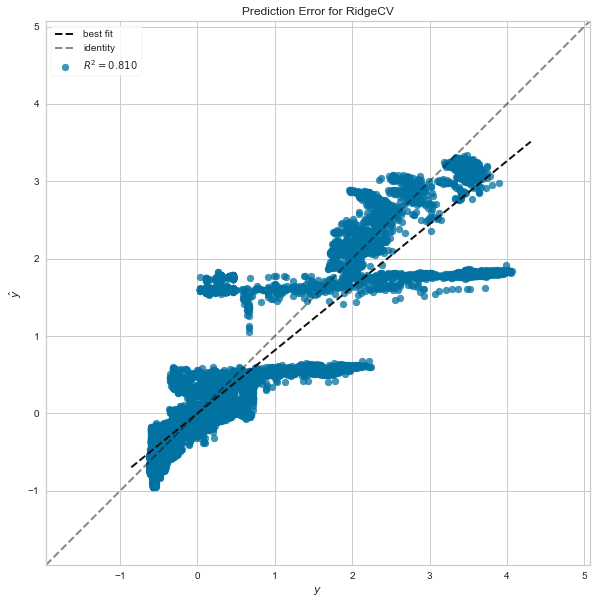

In [47]:
regr_cv = RidgeCV(alphas=[0.5, 100, 1000])
regr_cv.fit(X_train, y_train)

expected = y_test
predicted = regr_cv.predict(X_test)

print('Ridge model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(regr_cv, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

In [48]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
expected = y_test
predicted = regr_trans.predict(X_test)

print('Transformed target regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Transformed target regressor
Mean squared error = 0.200
R2 score = 0.798


Gradient boosting regressor
Mean squared error = 0.171
R2 score = 0.828


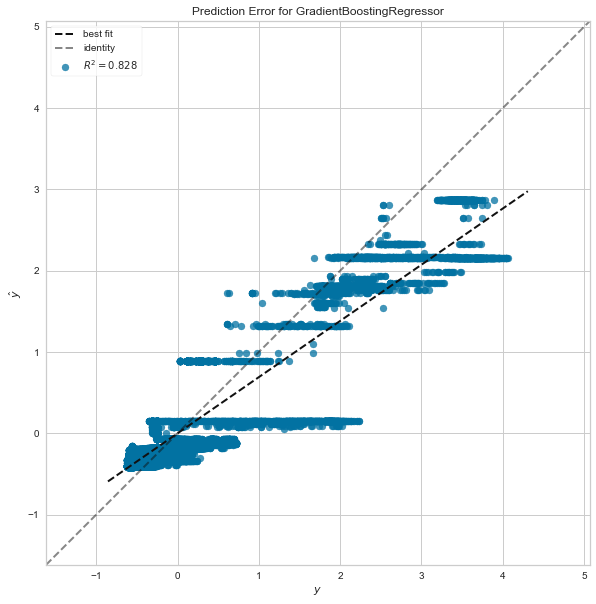

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
gb.fit(X_train,y_train)
expected = y_test
predicted = gb.predict(X_test)

print('Gradient boosting regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(gb, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Lasso
Mean squared error = 0.667
R2 score = 0.328


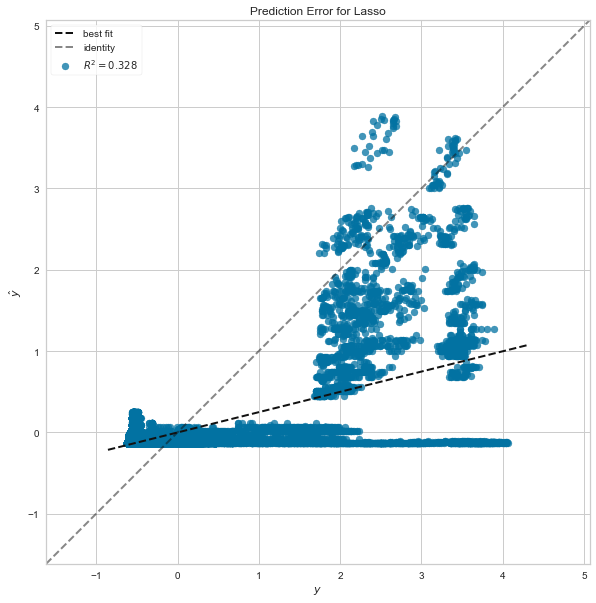

In [50]:
lasso = Lasso(alpha=0.2, max_iter=10e5)
lasso.fit(X_train,y_train)
expected = y_test
predicted = lasso.predict(X_test)

print('Lasso')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(lasso, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [51]:
elastic = ElasticNet(alpha=0.15, max_iter=10e5)
elastic.fit(X_train,y_train)
expected = y_test
predicted = elastic.predict(X_test)

print('Elastic')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Elastic
Mean squared error = 0.567
R2 score = 0.428


knn
Mean squared error = 0.110
R2 score = 0.889


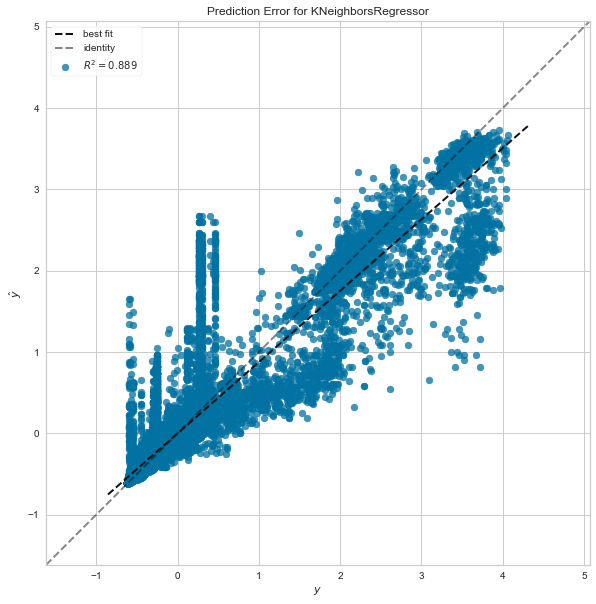

In [65]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(X_train,y_train)
expected = y_test
predicted = knn.predict(X_test)

print('knn')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(knn, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Random Forest Regressor
Mean squared error = 0.135
R2 score = 0.864


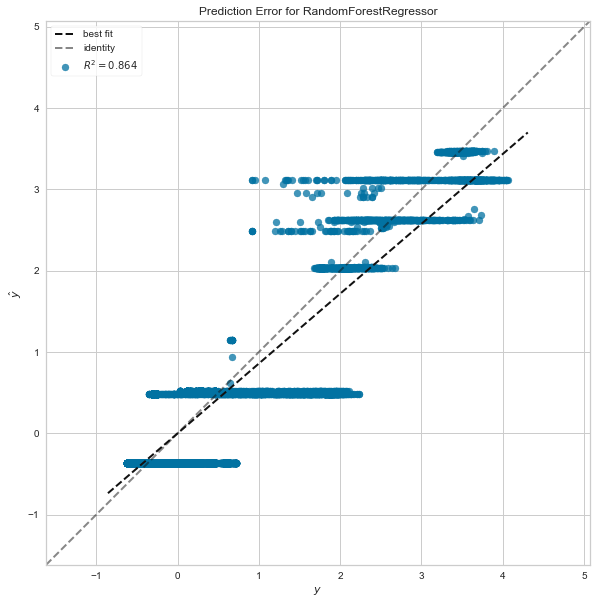

In [53]:
random_forest = RandomForestRegressor(n_estimators=50, max_depth=3)
random_forest.fit(X_train,y_train)
expected = y_test
predicted = random_forest.predict(X_test)

print('Random Forest Regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(random_forest, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

## Feature Analysis and Selection

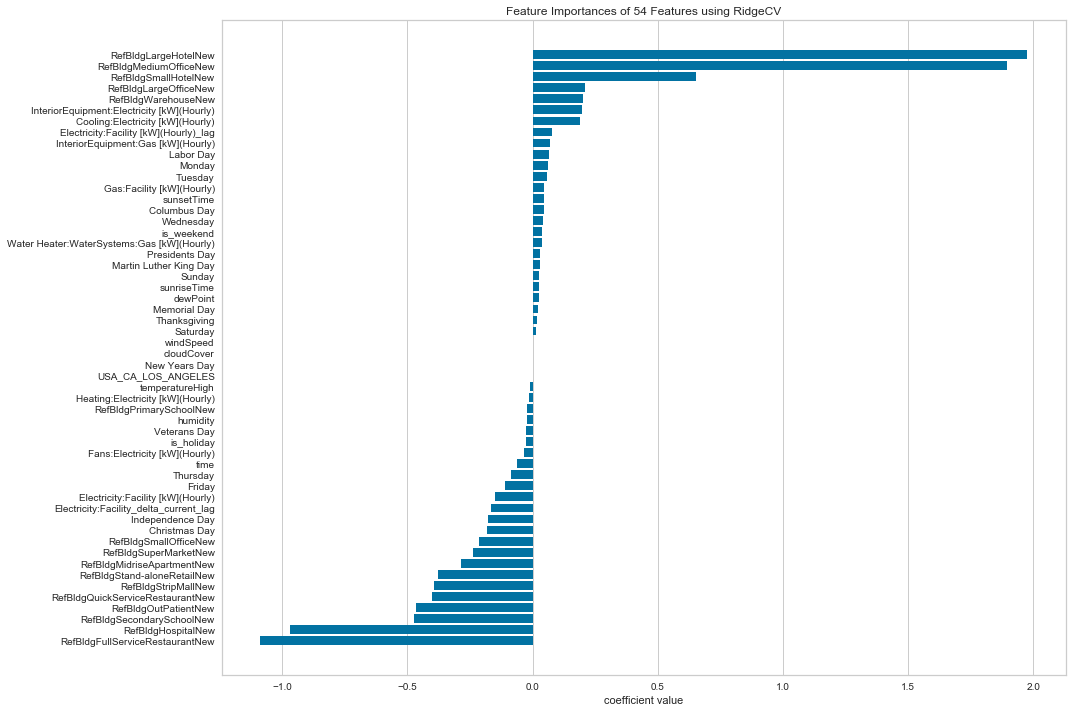

In [54]:
from yellowbrick.features import FeatureImportances

# model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(regr_cv, size=(1080, 720), relative=False)

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

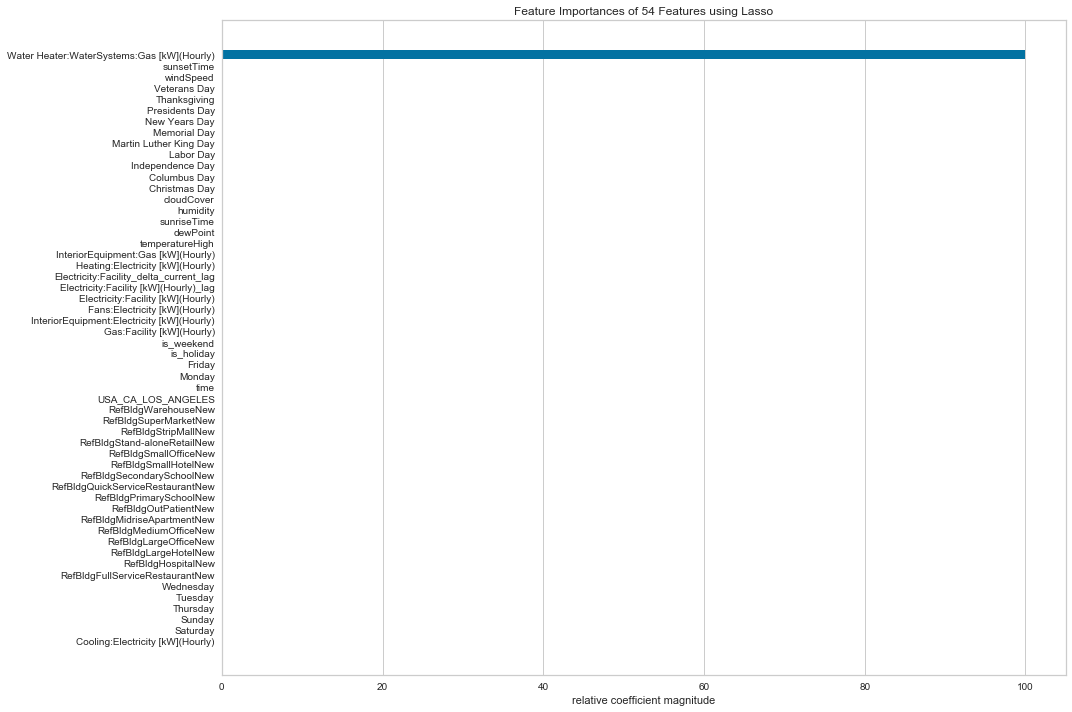

In [55]:
viz = FeatureImportances(lasso, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

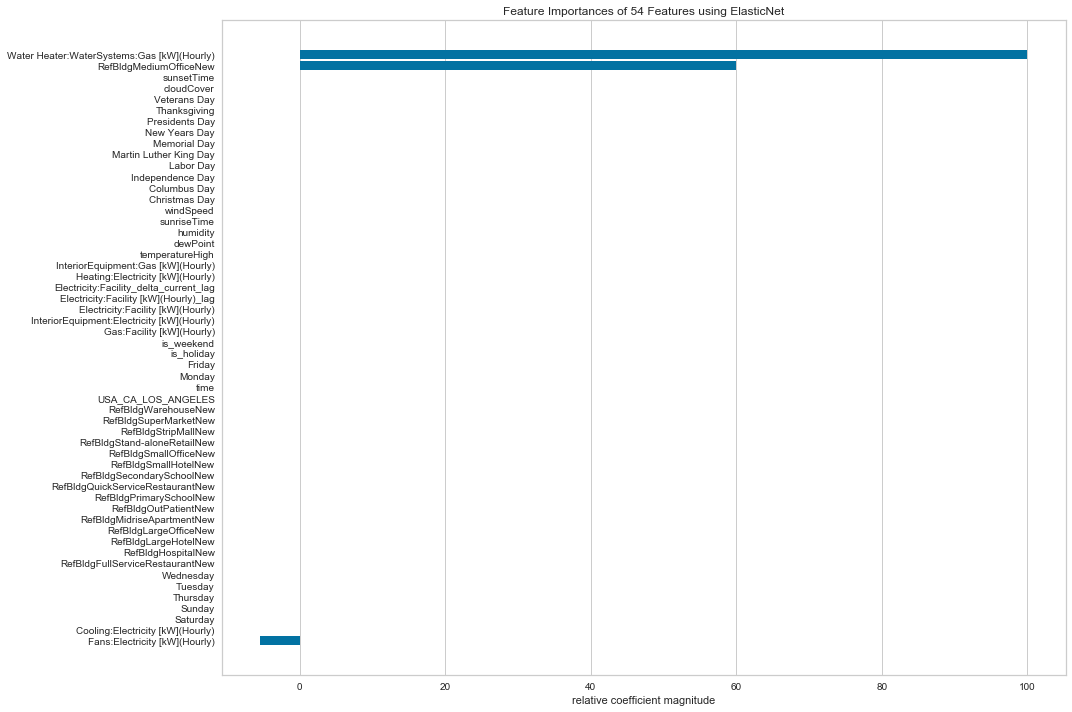

In [56]:
viz = FeatureImportances(elastic, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

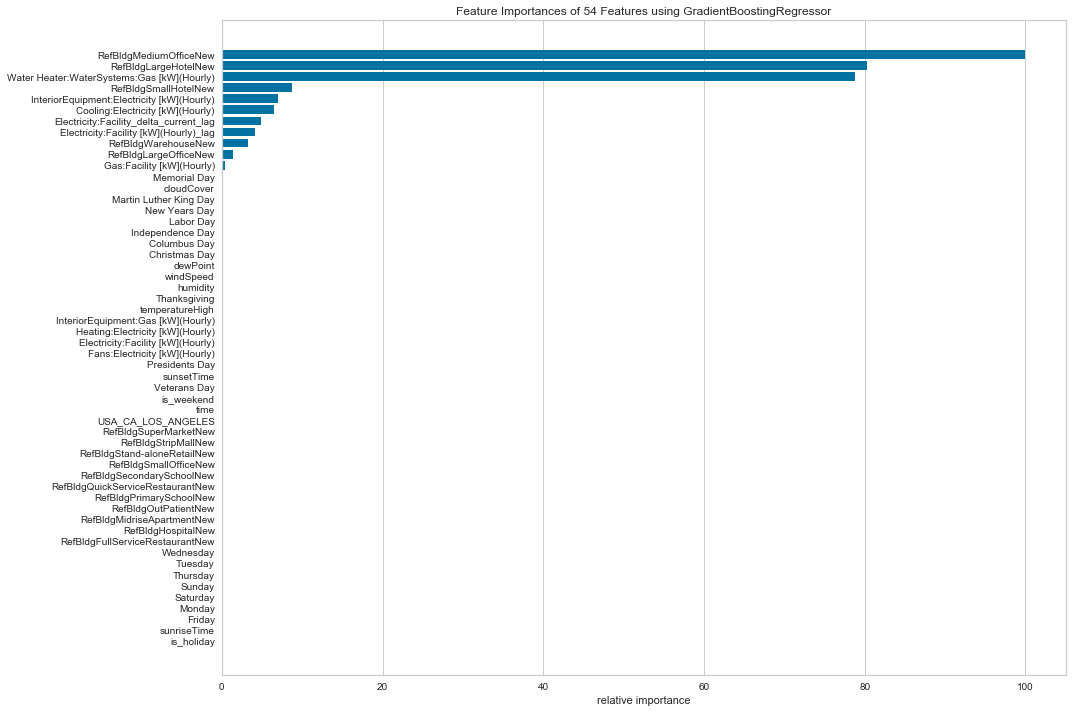

In [57]:
viz = FeatureImportances(gb, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

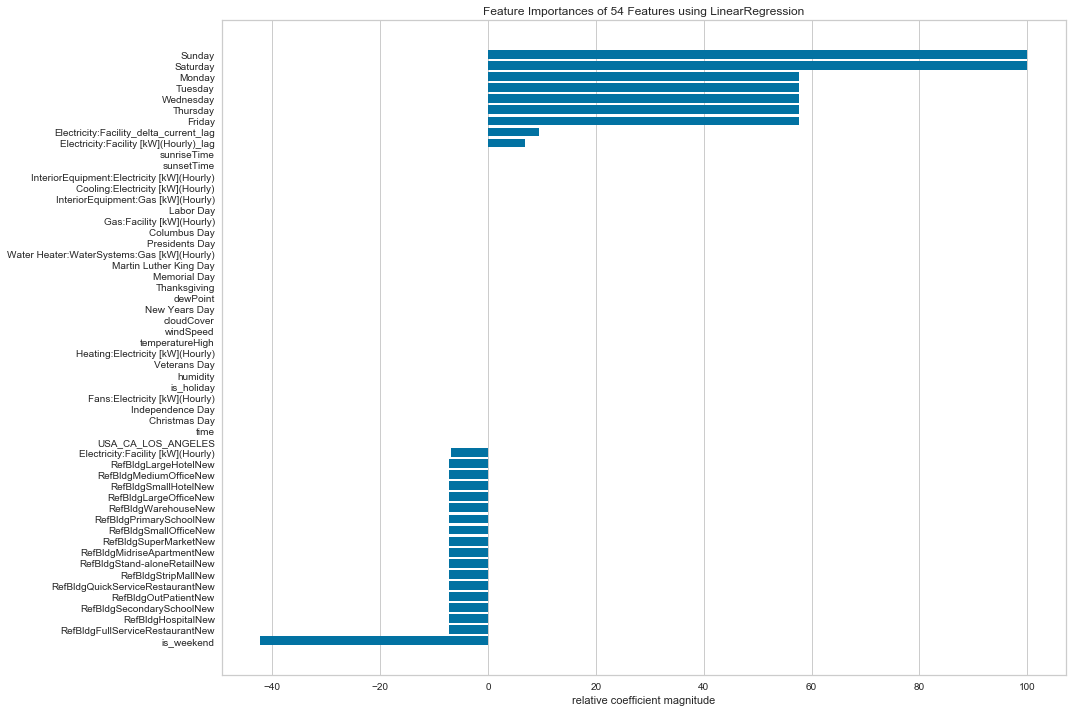

In [58]:
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

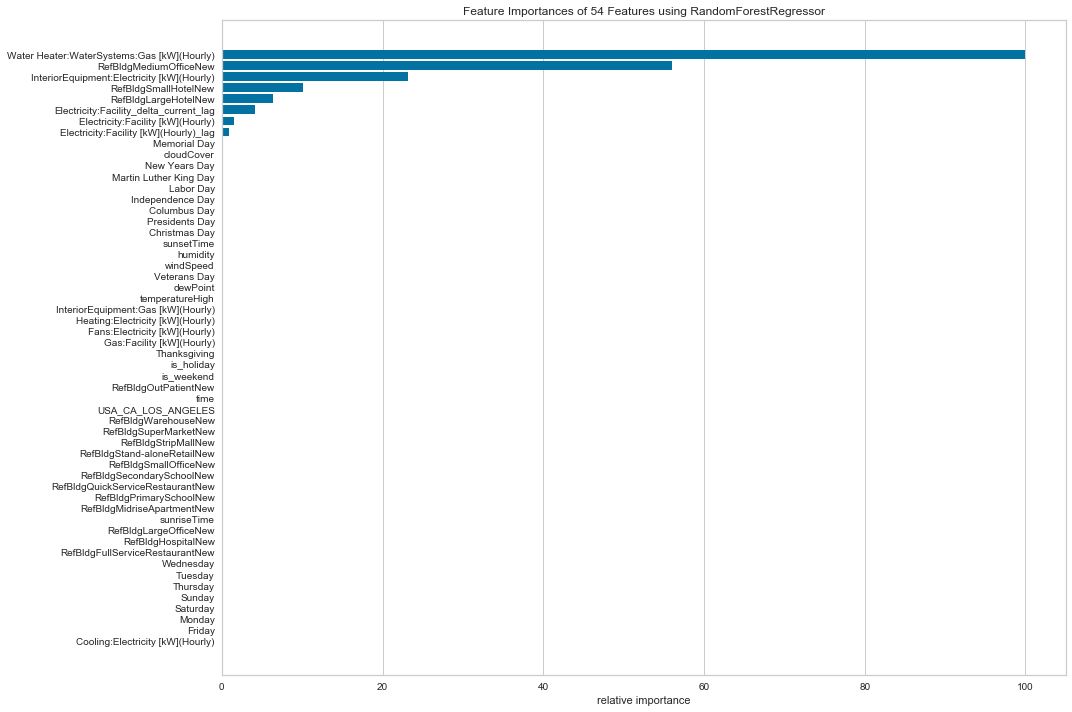

In [59]:
viz = FeatureImportances(random_forest, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

## Residual plots

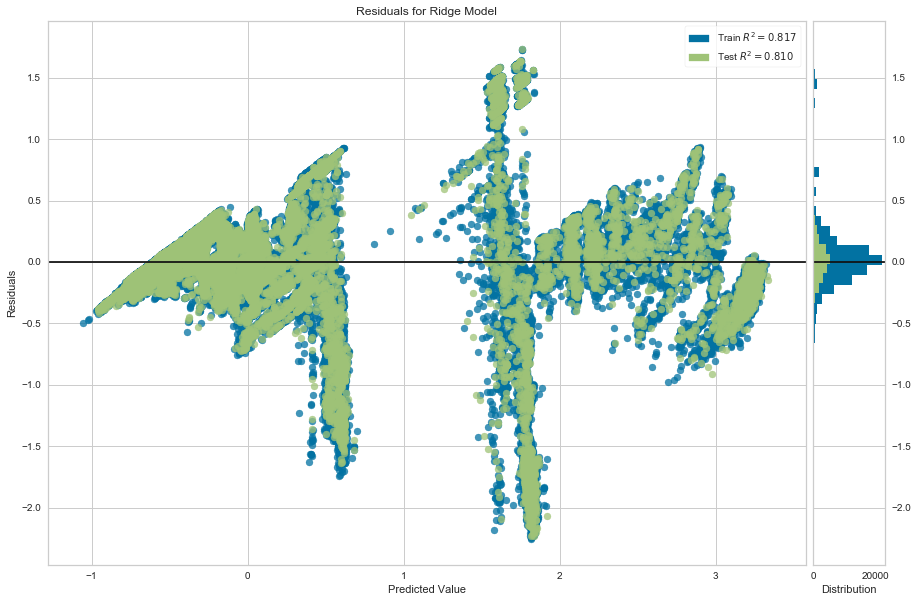

In [60]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

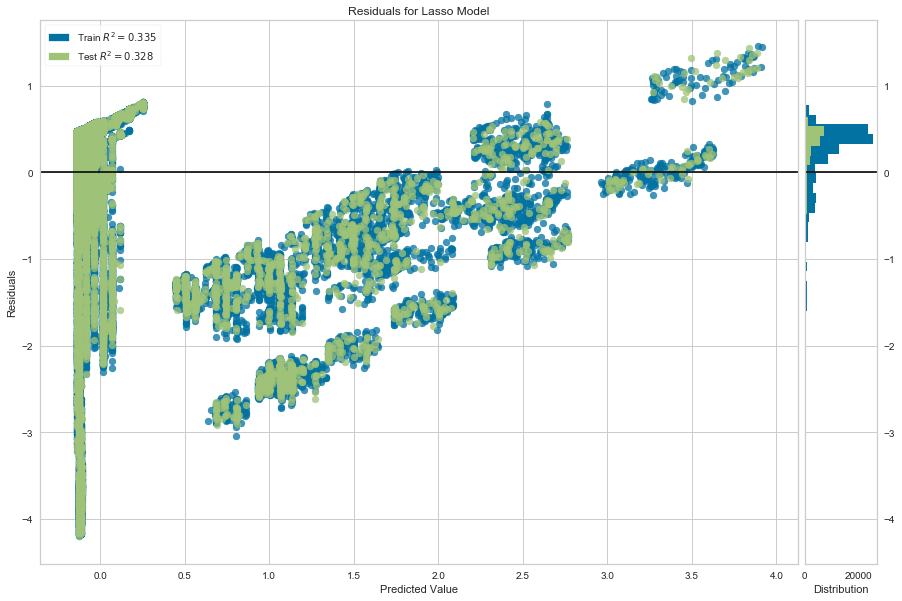

In [61]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Lasso(alpha=0.2, max_iter=10e5)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

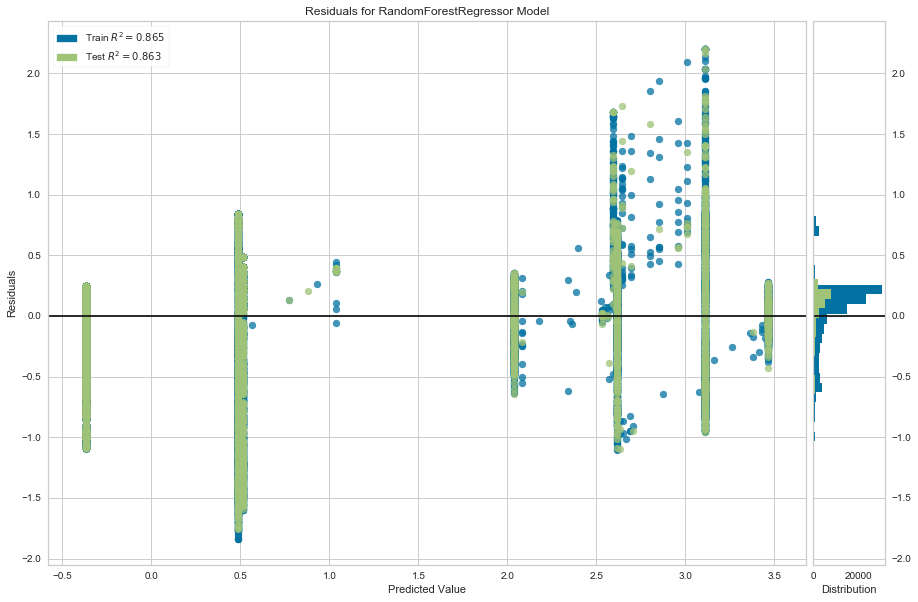

In [62]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = RandomForestRegressor(n_estimators=50, max_depth=3)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

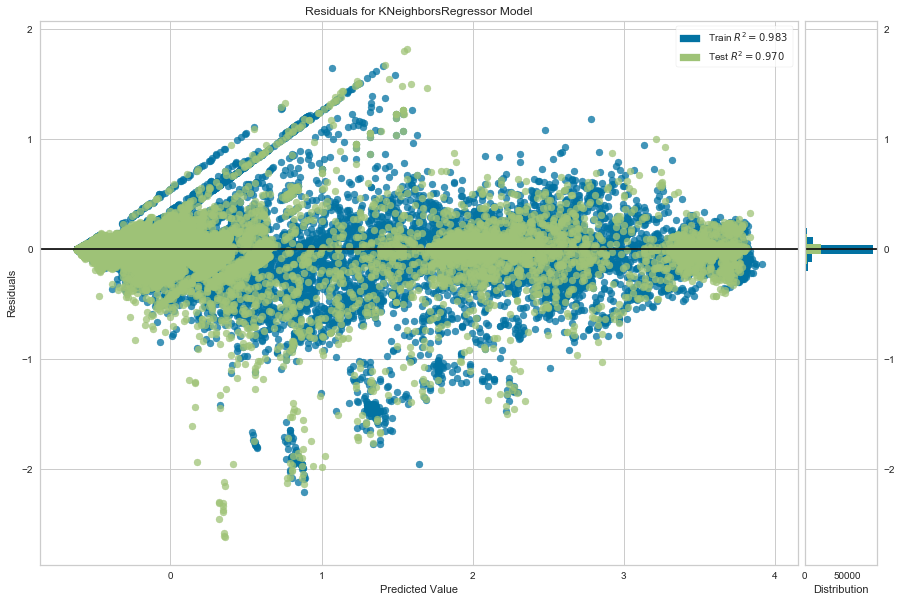

In [63]:
from sklearn.neighbors import KNeighborsRegressor

from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = KNeighborsRegressor()
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

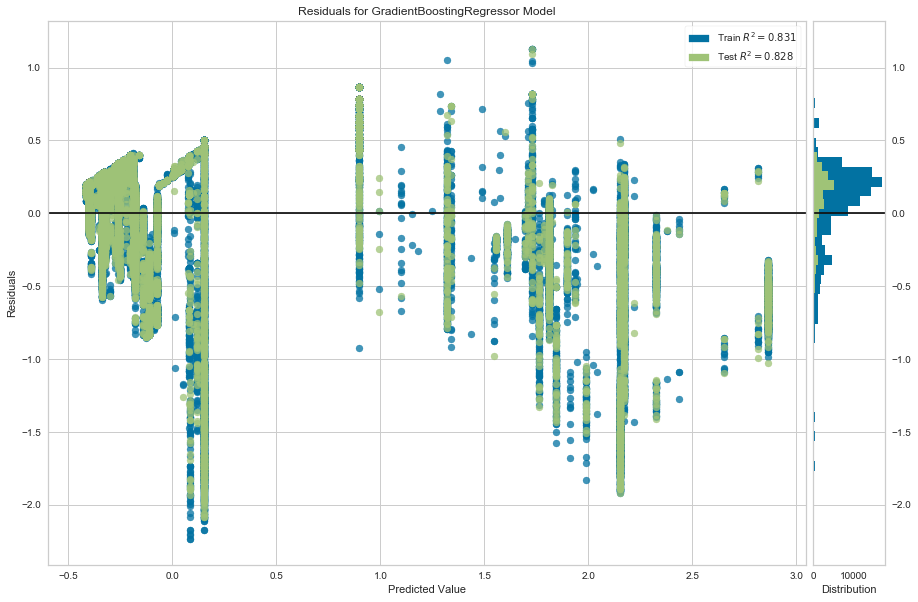

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
visualizer = ResidualsPlot(gb, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data